<a href="https://colab.research.google.com/github/Ayusharma24/CBAM-VGG16-Pneumonia-Detection/blob/main/CBAM_VGG16_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTERN PROJECT
****

In [6]:
!pip freeze | grep -E 'tensorflow|keras|matplotlib|numpy|scikit-learn|kaggle' > requirements.txt

In [7]:
!pip install -r requirements.txt

## AlexNet Model
****

1. **AlexNet** Architecture was proposed by Alex-team who won the **ILSVRC-2012** (**I**mageNet **L**arge **S**cale **V**isual **R**ecognition **C**hallenge - **2012**) competition & achieved a winning top-5 test error rate of 15.3%.

2. The architecture consists of (*Five*) Convolutional Layers, & (*Three*) Fully Connected Layers among which Final Layer is *Sigmoid*.

3. This architecture is also called as **Deep Neural Network**.

4. **Dropout** feature is added to ensure overfitting is avoided.

5. About Layers present in architecture **:**
   
   **(a)** **Convolutional Layer** - Applies filter or Kernels to the input image to extract the features and create feature maps.
   
   **(b)** **Max Pooling Layer** - Downsamples the image or reduces the dimensions of the feature maps, helping to extract the essential information & reduce computation.

   **(c)** **Fully Connected Layer** - Makes the final prediction.
   

### Model Implementation
**Install Required Libraries**
****



In [ ]:
# Install required libraries first
#!pip install tensorflow keras kaggle

**Mount Google Drive**
****

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Required Libraries**
****

In [9]:
# Now, import all necessary libraries
try:
    import numpy as np
    import matplotlib.pyplot as plt
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, load_model
    from tensorflow.keras.layers import (
        Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
        BatchNormalization, GlobalAveragePooling2D
    )
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.applications import (
        VGG16, VGG19, ResNet50, EfficientNetB0
    )
    from sklearn.metrics import confusion_matrix, f1_score

    print("All libraries imported successfully.")

except ImportError as e:
    print(f"Error importing libraries: {e}")

All libraries imported successfully.


**Upload Kaggle .json File**
****

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayusharma24","key":"c3902891836a0ae4be1ae8c86b3db60d"}'}

**Move Kaggle .json File**
****

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


**Download the dataset**
****
We have downloaded the *pediatric-pneumonia-chest-x-ray* dataset.

**Pediatric pneumonia** is an infection in the lungs that can affect children of all ages.

**Causes:**
1. Pneumonia in children can be caused by viruses, bacteria, and fungi.

2. Common causes include respiratory syncytial virus (RSV), bacterial infections, and complications from other illnesses like COVID-19 or the flu.

In [ ]:
!kaggle datasets download -d andrewmvd/pediatric-pneumonia-chest-xray

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray
License(s): Attribution 4.0 International (CC BY 4.0)


**Unzip the downloaded dataset**
****

In [ ]:
!unzip -q pediatric-pneumonia-chest-xray.zip

**Load & Preprocess the dataset**
****
We have split our training dataset into two parts:
1. The Training set, consists of 80% of the data.
2. The Validation set, consists of 20% of the remaining data.

Also, we have resized all images into 227 * 227 dimensions.

In [ ]:
# Paths to the dataset
train_dir = '/content/Pediatric Chest X-ray Pneumonia/train'
test_dir = '/content/Pediatric Chest X-ray Pneumonia/test'

# ImageDataGenerator with validation split for training
train_datagen = ImageDataGenerator(rescale=1./255.0, validation_split=0.2)  # 20% for validation
test_datagen = ImageDataGenerator(rescale=1./255.0)

# Training generator (excluding validation data)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='binary',
    subset='training'  # Using only training data
)

# Validation generator (taken from training set)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='binary',
    subset='validation'  # Using 20% of training data as validation
)

# Test generator (unchanged)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='binary'
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Define model architecture**
****

In [ ]:
# Define and Compile the AlexNet Model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=(227, 227, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# 3rd, 4th, 5th Convolutional Layers
model.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Define Model Callbacks**
****
**Callbacks** are the set of functions or an object which is executed at the specific stage of the training procedure, & allow us to gain insights into the model's internal states & statistics.


We are using following callbacks:
1. **ModelCheckpoint** callback which is especially used when our model performs well on validation data.

2. **ReduceLROnPlateau** callback is used to reduce the learning rate when *val_loss* has stopped improving.

3. **Early Stopping** callback to stop training early if certain conditions (eg. validation loss not improving) are met. This helps prevent overfitting.

In [ ]:
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='Alexnet.keras',  # Path where the model weights will be saved
    monitor='val_accuracy',    # Quantity to monitor
    mode='max',                # Mode: maximize the quantity
    save_best_only=True,       # Save only the best model (best value of the monitored quantity)
    verbose=1                  # Verbosity level, 1 for updates on save
)

# Define the reduce learning rate on plateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',        # Quantity to monitor
    factor=0.1,                # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,                # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,               # Lower bound on the learning rate
    verbose=1                  # Verbosity level, 1 for updates
)

# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',        # Quantity to monitor
    patience=5,                # Number of epochs with no improvement after which training will be stopped
    verbose=1,                 # Verbosity level, 1 for updates
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Compile the list of callbacks
callbacks_list = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

**Compile the Model**
****

In [ ]:
# Compile the model using the updated parameter name
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])

**Train the Model**
****

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks_list,
    epochs=30
)

Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.9526 - loss: 0.1346
Epoch 1: val_accuracy did not improve from 0.74609
65/65 ━━━━━━━━━━━━━━━━━━━━ 50s 771ms/step - accuracy: 0.9527 - loss: 0.1345 - val_accuracy: 0.7422 - val_loss: 2.0513 - learning_rate: 1.0000e-05
Epoch 2/30
 1/65 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9531 - loss: 0.0741
Epoch 2: val_accuracy did not improve from 0.74609
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9531 - loss: 0.0741 - val_accuracy: 0.7422 - val_loss: 2.0624 - learning_rate: 1.0000e-05
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9692 - loss: 0.0882
Epoch 3: val_accuracy did not improve from 0.74609
65/65 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9692 - loss: 0.0882 - val_accuracy: 0.7412 - val_loss: 3.0717 - learning_rate: 1.0000e-05
Epoch 4/30
 1/65 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9688 - loss: 0.0793
Epoch 4: val_accuracy did not improve from 0.74609
65/65 ━━━━━━━━━━━

**Evaluate the Model & Visualize the Results**
****

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 581ms/step - accuracy: 0.8001 - loss: 0.7856
Test Accuracy: 0.8125
Test Loss: 0.7042


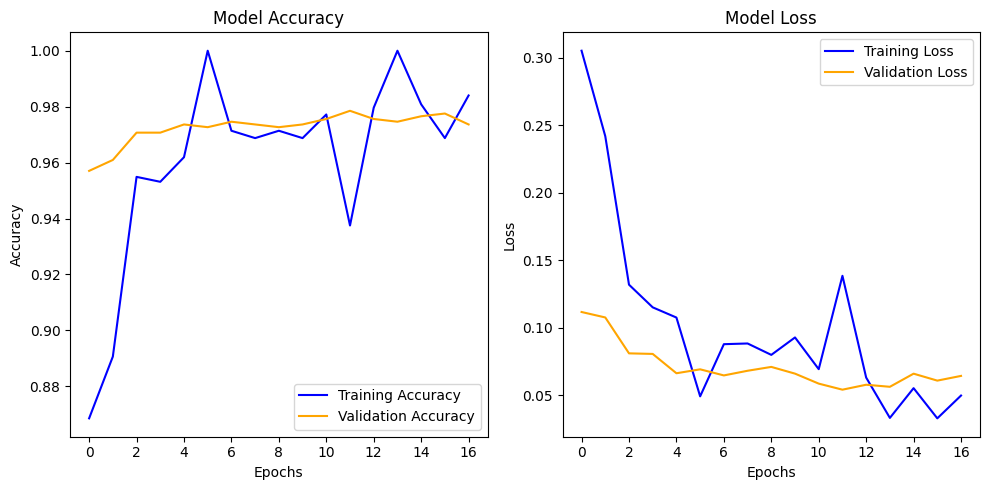

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


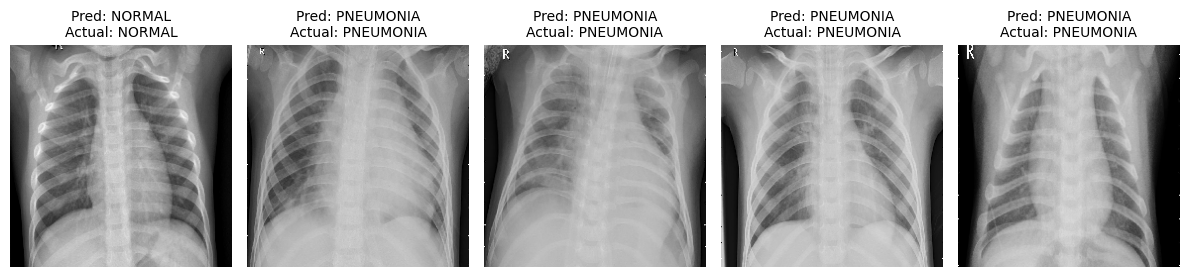

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Function to visualize training history
def plot_training_history(history):
    plt.figure(figsize=(10, 5))  # Adjust figure size

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')  # Changed to orange
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Changed to orange
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot training history
plot_training_history(history)

# Function to visualize predictions on test images
def visualize_predictions(model, test_generator, num_images=5):
    # Get class labels
    class_indices = test_generator.class_indices
    class_names = list(class_indices.keys())  # Extract actual class names dynamically

    # Get a batch of test images & labels
    test_images, true_labels = next(test_generator)
    true_labels = true_labels.astype(int)

    # Make predictions
    predictions = model.predict(test_images)
    predicted_labels = np.round(predictions).astype(int).reshape(-1)

    # Display images with predictions
    plt.figure(figsize=(12, 6))  # Optimized figure size
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[i])
        plt.title(f'Pred: {class_names[predicted_labels[i]]}\nActual: {class_names[true_labels[i]]}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call function to display 5 test images with predictions
visualize_predictions(model, test_generator, num_images=5)


**Save Model**
****

In [ ]:
# Assuming 'model' is your trained Keras model
model.save('/content/drive/MyDrive/Colab Notebooks/AlexNet Model.h5')


## VGG 16 Model
****
1. VGG 16 was developed by Simonyan & Zisserman in 2014. It is preferred as it has a very uniform architecture.

2. This has **13** convolutional layers & **3** Fully Connected Layers.

3. It has *138 million* parameters which is certainly difficult to handle.

4. It Uses the concept of **3x3** kernel size & stride of **1** for all convolutional layers and **2x2** kernel size & stride of **2** for Max Pooling layers followed by three fully connected layers with **4096** neurons in each.

5. The final layer has **1000** neurons & uses *Softmax activation function* for classification.

### Model Implementation

**Load & Preprocess the dataset**
****

In [ ]:
# Paths to the dataset
train_dir = '/content/Pediatric Chest X-ray Pneumonia/train'
test_dir = '/content/Pediatric Chest X-ray Pneumonia/test'

# ImageDataGenerator with validation split for training
train_datagen = ImageDataGenerator(rescale=1./255.0, validation_split=0.2)  # 20% for validation
test_datagen = ImageDataGenerator(rescale=1./255.0)

# Training generator (excluding validation data)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Changed to (224, 224)
    batch_size=64,
    class_mode='binary',
    subset='training'  # Using only training data
)

# Validation generator (taken from training set)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Changed to (224, 224)
    batch_size=64,
    class_mode='binary',
    subset='validation'  # Using 20% of training data as validation
)

# Test generator (unchanged)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Changed to (224, 224)
    batch_size=64,
    class_mode='binary'
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Define & Compile the VGG 16 Model**
****

In [ ]:
# Load the pre-trained VGG16 model without the fully connected (FC) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
base_model.trainable = False

# Add custom layers on top of VGG16
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Increased dropout for better generalization
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

**Define Model Callbacks**
****

In [ ]:
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='VGG16.keras',  # Path where the model weights will be saved
    monitor='val_accuracy',    # Quantity to monitor
    mode='max',                # Mode: maximize the quantity
    save_best_only=True,       # Save only the best model (best value of the monitored quantity)
    verbose=1                  # Verbosity level, 1 for updates on save
)

# Define the reduce learning rate on plateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',        # Quantity to monitor
    factor=0.1,                # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,                # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,               # Lower bound on the learning rate
    verbose=1                  # Verbosity level, 1 for updates
)

# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',        # Quantity to monitor
    patience=5,                # Number of epochs with no improvement after which training will be stopped
    verbose=1,                 # Verbosity level, 1 for updates
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Compile the list of callbacks
callbacks_list = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

**Compile The Model**
****

In [ ]:
# Compile the model using the updated parameter name
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])


**Train the Model**
****

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks_list,
    epochs=30
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.7926 - loss: 0.4586
Epoch 1: val_accuracy improved from -inf to 0.95703, saving model to VGG16.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7938 - loss: 0.4562 - val_accuracy: 0.9570 - val_loss: 0.1116 - learning_rate: 1.0000e-04
Epoch 2/30
 1/65 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - accuracy: 0.8906 - loss: 0.2419

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.95703 to 0.96094, saving model to VGG16.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.8906 - loss: 0.2419 - val_accuracy: 0.9609 - val_loss: 0.1075 - learning_rate: 1.0000e-04
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.9517 - loss: 0.1389
Epoch 3: val_accuracy improved from 0.96094 to 0.97070, saving model to VGG16.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9517 - loss: 0.1388 - val_accuracy: 0.9707 - val_loss: 0.0809 - learning_rate: 1.0000e-04
Epoch 4/30
 1/65 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - accuracy: 0.9531 - loss: 0.1150
Epoch 4: val_accuracy did not improve from 0.97070
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - accuracy: 0.9531 - loss: 0.1150 - val_accuracy: 0.9707 - val_loss: 0.0805 - learning_rate: 1.0000e-04
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9596 - loss: 0.1125
Epoch 5: val_accuracy improved from 0.97070 to 0.97363, saving model to VGG16.keras
65

**Evaluate the Model & Visualize the Results**
****


19/19 [==============================] - 6s 304ms/step - loss: 0.8438 - accuracy: 0.7714
Test Accuracy: 0.7713815569877625
Test Loss: 0.8438369631767273


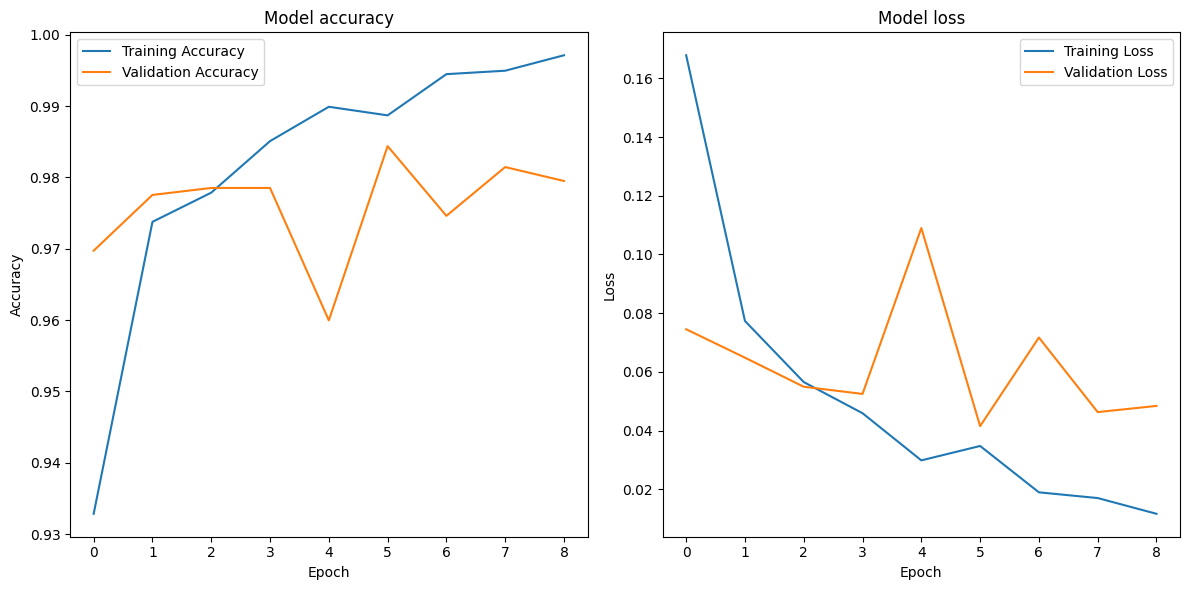

1/1 [==============================] - 0s 165ms/step


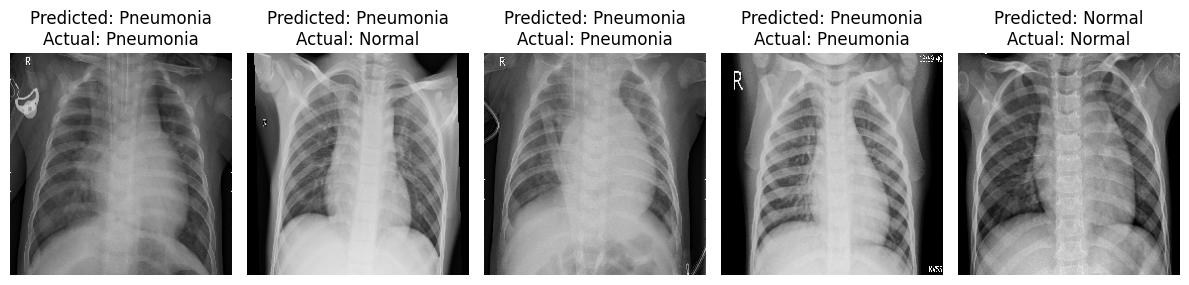

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Visualize training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Visualize predictions on a few test images
def visualize_predictions(model, test_generator, num_images=5):
    class_names = ['MSInstability', 'MSStability']  # For binary classification task

    # Get predictions and true labels from the generator
    test_images, true_labels = next(test_generator)
    true_labels = true_labels.astype(int)

    # Make predictions
    predictions = model.predict(test_images)
    predicted_labels = np.round(predictions).astype(int).reshape(-1)

    plt.figure(figsize=(15, 8))  # Increase figure size to accommodate more images
    for i in range(num_images):
        if i >= len(test_images):
            break  # Avoid index error if num_images > available images in the batch
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[i])
        plt.title(f'Predicted: {class_names[predicted_labels[i]]}\nActual: {class_names[true_labels[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with the desired number of images
visualize_predictions(model, test_generator, num_images=10)

**Save Model**
****

In [ ]:
# Assuming 'model' is your trained Keras model
model.save('/content/drive/MyDrive/Colab Notebooks/VGG16 Model.h5')


## VGG 19 Model
****
1. **VGG 19** is a variant of the VGG model (Visual Geometry Group) Model, which consists of **19** layers.

2. There are **16** convolutional layers with **3x3** kernels & each convolutional layer is followed by ReLU activation.

3. Max pooling is performed over **2x2** pixel window with a stride of **2**.

4. Three fully connected layers with **4096** neurons in each.

5. The final layer has **1000** neurons & uses *Softmax activation function* for classification.

### Model Implementation
**Load & Preprocess the dataset**
****

In [ ]:
# Paths to the dataset
train_dir = '/content/Pediatric Chest X-ray Pneumonia/train'
test_dir = '/content/Pediatric Chest X-ray Pneumonia/test'

# ImageDataGenerator with validation split (20%) for training
train_datagen = ImageDataGenerator(rescale=1./255.0,validation_split=0.2)  # 20% of training data used for validation

test_datagen = ImageDataGenerator(rescale=1./255.0)

# Training generator (excluding validation data)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Required for VGG19
    batch_size=64,
    class_mode='binary',
    subset='training',  # Using 80% of data for training
    shuffle=True
)

# Validation generator (20% split from training)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Required for VGG19
    batch_size=64,
    class_mode='binary',
    subset='validation',  # Using 20% of data for validation
    shuffle=False
)

# Test generator (unchanged)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Required for VGG19
    batch_size=64,
    class_mode='binary',
    shuffle=False
)


Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Define & Compile the VGG 19 Model**
****

In [ ]:
# Load the VGG19 model without the top layer (fully connected layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
base_model.trainable = False

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),  # Increased neurons for better feature extraction
    Dropout(0.4),  # Increased dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification output
])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Define Model Callbacks**
****

In [ ]:
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='VGG19.keras',  # Path where the model weights will be saved
    monitor='val_accuracy',    # Quantity to monitor
    mode='max',                # Mode: maximize the quantity
    save_best_only=True,       # Save only the best model (best value of the monitored quantity)
    verbose=1                  # Verbosity level, 1 for updates on save
)

# Define the reduce learning rate on plateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',        # Quantity to monitor
    factor=0.1,                # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,                # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,               # Lower bound on the learning rate
    verbose=1                  # Verbosity level, 1 for updates
)

# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',        # Quantity to monitor
    patience=5,                # Number of epochs with no improvement after which training will be stopped
    verbose=1,                 # Verbosity level, 1 for updates
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Compile the list of callbacks
callbacks_list = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

**Compile The Model**
***

In [ ]:
# Compile the model using the updated parameter name
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])

**Train the Model**
****

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks_list,
    epochs=30
)

Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.7724 - loss: 0.4684
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to VGG19.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 69s 985ms/step - accuracy: 0.7736 - loss: 0.4663 - val_accuracy: 0.9375 - val_loss: 0.1549 - learning_rate: 1.0000e-04
Epoch 2/30
 1/65 ━━━━━━━━━━━━━━━━━━━━ 21s 337ms/step - accuracy: 0.9531 - loss: 0.1412
Epoch 2: val_accuracy improved from 0.93750 to 0.94141, saving model to VGG19.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.9531 - loss: 0.1412 - val_accuracy: 0.9414 - val_loss: 0.1493 - learning_rate: 1.0000e-04
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9369 - loss: 0.1653
Epoch 3: val_accuracy improved from 0.94141 to 0.95898, saving model to VGG19.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9371 - loss: 0.1650 - val_accuracy: 0.9590 - val_loss: 0.1069 - learning_rate: 1.0000e-04
Epoch 4/30
 1/65 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - ac

**Evaluate the Model & Visualize the Results**
****

19/19 [==============================] - 6s 327ms/step - loss: 1.1560 - accuracy: 0.7549
Test Accuracy: 0.7549341917037964
Test Loss: 1.1560386419296265


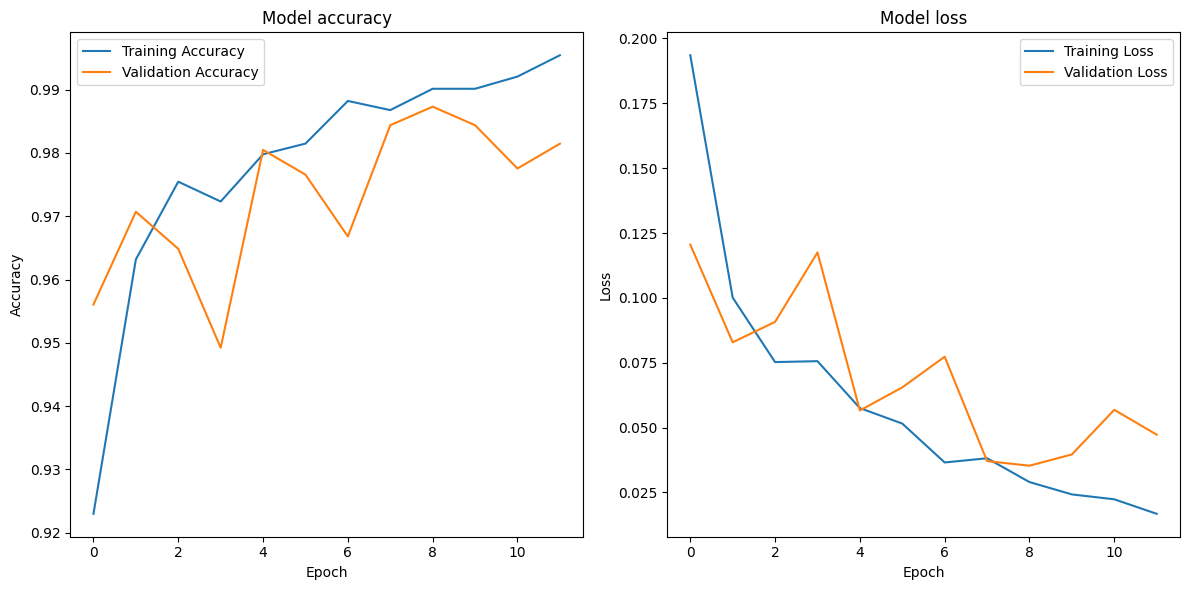

1/1 [==============================] - 0s 180ms/step


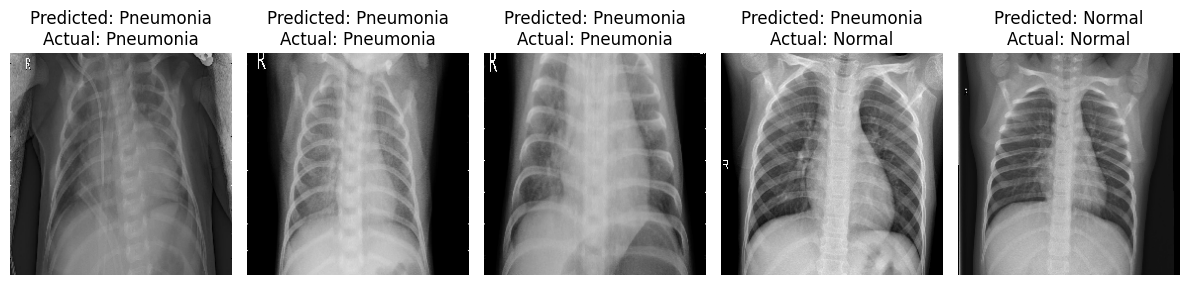

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Visualize training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Visualize predictions on a few test images
def visualize_predictions(model, test_generator, num_images=5):
    class_names = ['MSInstability', 'MSStability']  # Assuming binary classification

    # Get predictions and true labels from the generator
    test_images, true_labels = next(test_generator)
    true_labels = true_labels.astype(int)

    # Make predictions
    predictions = model.predict(test_images)
    predicted_labels = np.round(predictions).astype(int).reshape(-1)

    plt.figure(figsize=(15, 8))  # Increase figure size to accommodate more images
    for i in range(num_images):
        if i >= len(test_images):
            break  # Avoid index error if num_images > available images in the batch
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[i])
        plt.title(f'Predicted: {class_names[predicted_labels[i]]}\nActual: {class_names[true_labels[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with the desired number of images
visualize_predictions(model, test_generator, num_images=10)

**Save The Model**

In [ ]:
# Assuming 'model' is your trained Keras model
model.save('/content/drive/MyDrive/Colab Notebooks/VGG19 Model.h5')


## Resnet-50 Model
****
1. ResNet-50 is a CNN architecture that belongs to the **ResNet (Residual Networks) family**, developed by researchers at Microsoft Research Asia.

2. ResNet-50 addresses challenges associated with training deep neural networks (i.e., vanishing/exploding gradient problem).

3. It consists of **48** convolutional layers, **1** Max Pool layer & **1** Average Pool layer.

4. It uses Shortcut connections (also known as identity mappings), which allows ultra-deep neural networks to converge effectively.

### Model Implementation
**Load & Preprocess the dataset**
****

In [ ]:
# Paths to the dataset
train_dir = '/content/Pediatric Chest X-ray Pneumonia/train'
test_dir = '/content/Pediatric Chest X-ray Pneumonia/test'

# ImageDataGenerator with validation split for training
train_datagen = ImageDataGenerator(
    rescale=1./255.0,
    validation_split=0.2,  # 20% for validation
    horizontal_flip=True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255.0)

# Training generator (excluding validation data)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # ResNet50 expects (224, 224)
    batch_size=64,
    class_mode='binary',
    subset='training'  # Using only training data
)

# Validation generator (taken from training set)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # ResNet50 expects (224, 224)
    batch_size=64,
    class_mode='binary',
    subset='validation'  # Using 20% of training data as validation
)

# Test generator (unchanged)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # ResNet50 expects (224, 224)
    batch_size=64,
    class_mode='binary'
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Define & Compile the ResNet-50 Model**
****

In [ ]:
# Load the ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
base_model.trainable = False

# Define the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replaces Flatten() for better efficiency
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])


**Define Model Callbacks**
****

In [ ]:
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='VGG19.keras',  # Path where the model weights will be saved
    monitor='val_accuracy',    # Quantity to monitor
    mode='max',                # Mode: maximize the quantity
    save_best_only=True,       # Save only the best model (best value of the monitored quantity)
    verbose=1                  # Verbosity level, 1 for updates on save
)

# Define the reduce learning rate on plateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',        # Quantity to monitor
    factor=0.1,                # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,                # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,               # Lower bound on the learning rate
    verbose=1                  # Verbosity level, 1 for updates
)

# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',        # Quantity to monitor
    patience=5,                # Number of epochs with no improvement after which training will be stopped
    verbose=1,                 # Verbosity level, 1 for updates
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Compile the list of callbacks
callbacks_list = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

**Compile The Model**
****

In [ ]:
# Compile the model using the updated parameter name
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])

**Train the Model**
****

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks_list,
    epochs=30
)

Epoch 1/20
130/130 [==============================] - ETA: 0s - loss: 0.5578 - accuracy: 0.7430
Epoch 1: val_accuracy improved from -inf to 0.82910, saving model to ResNet50_model.keras
130/130 [==============================] - 74s 523ms/step - loss: 0.5578 - accuracy: 0.7430 - val_loss: 0.4028 - val_accuracy: 0.8291
Epoch 2/20
130/130 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.8306
Epoch 2: val_accuracy did not improve from 0.82910
130/130 [==============================] - 63s 482ms/step - loss: 0.3805 - accuracy: 0.8306 - val_loss: 0.4053 - val_accuracy: 0.7881
Epoch 3/20
130/130 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8532
Epoch 3: val_accuracy improved from 0.82910 to 0.84863, saving model to ResNet50_model.keras
130/130 [==============================] - 57s 442ms/step - loss: 0.3299 - accuracy: 0.8532 - val_loss: 0.3268 - val_accuracy: 0.8486
Epoch 4/20
130/130 [==============================] - ETA: 0s - loss: 0.2977

**Evaluate the Model & Visualize the Results**
****

19/19 [==============================] - 5s 258ms/step - loss: 0.7345 - accuracy: 0.7385
Test Accuracy: 0.7384868264198303
Test Loss: 0.7345490455627441


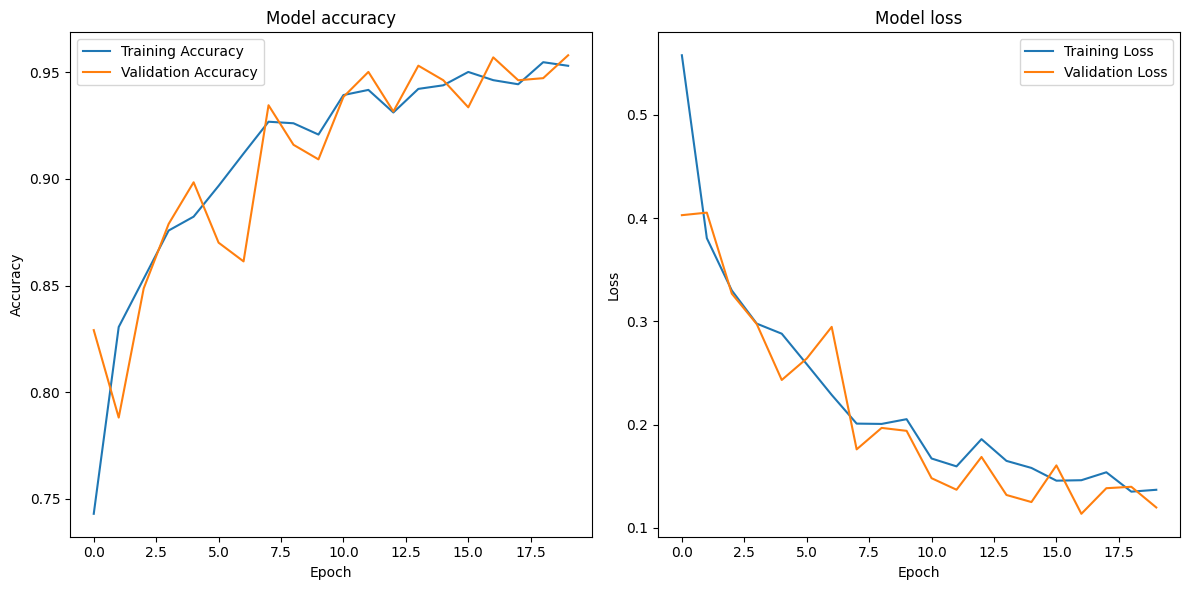

1/1 [==============================] - 1s 922ms/step


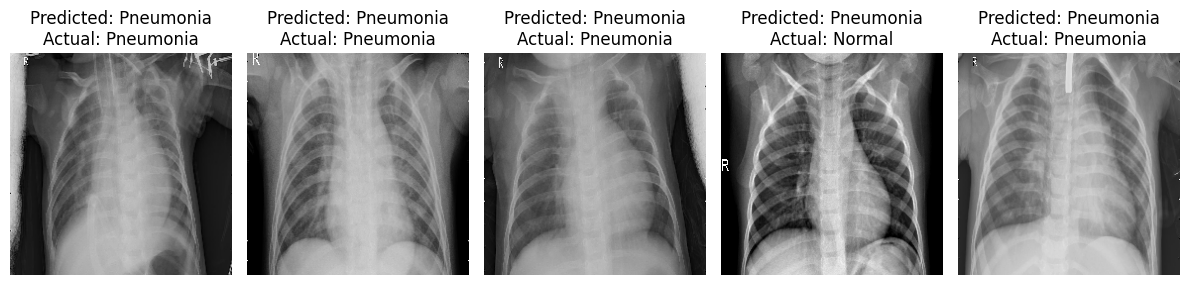

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Visualize training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Visualize predictions on a few test images
def visualize_predictions(model, test_generator, num_images=5):
    class_names = ['MSInstability', 'MSStability']  # Assuming binary classification

    # Get predictions and true labels from the generator
    test_images, true_labels = next(test_generator)
    true_labels = true_labels.astype(int)

    # Make predictions
    predictions = model.predict(test_images)
    predicted_labels = np.round(predictions).astype(int).reshape(-1)

    plt.figure(figsize=(15, 8))  # Increase figure size to accommodate more images
    for i in range(num_images):
        if i >= len(test_images):
            break  # Avoid index error if num_images > available images in the batch
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[i])
        plt.title(f'Predicted: {class_names[predicted_labels[i]]}\nActual: {class_names[true_labels[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with the desired number of images
visualize_predictions(model, test_generator, num_images=10)

**Save The Model**
****

In [ ]:
# Assuming 'model' is your trained Keras model
model.save('/content/drive/MyDrive/Colab Notebooks/ResNet50 Model.h5')


## EfficientNet B0 Model
****
1. The EfficientNet-B0 architecture is part of the **EfficientNet family of convolutional neural networks** (CNNs), developed by researchers from Google Research.

2. It uses **compound scaling** method that optimizes *network depth, width & resolution* simultaneously.

3. The initial layer consists of a **3x3** convolution with **32** Filters and a stride of **2** followed by batch normalization and a ReLU activation.

4. The body comprises a series of **Mobile Inverted Bottleneck (MBConv) blocks** & each block combines **depth-wise separable convolutions** and **squeeze-and-excitation** (SE) layers.

5. The head includes a final convolutional block followed by **global average pooling** & a fully connected layer with a softmax activation function to perform classification.

6. EfficientNet aims to strike a balance between *model complexity and computational efficiency*.

### Model Implementation
**Load & Preprocess the dataset**
****

In [ ]:
# Paths to the dataset
train_dir = '/content/Pediatric Chest X-ray Pneumonia/train'
test_dir = '/content/Pediatric Chest X-ray Pneumonia/test'

# ImageDataGenerator with validation split for training
train_datagen = ImageDataGenerator(rescale=1./255.0, validation_split=0.2)  # 20% for validation
test_datagen = ImageDataGenerator(rescale=1./255.0)

# Training generator (excluding validation data)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='binary',
    subset='training'  # Using only training data
)

# Validation generator (taken from training set)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='binary',
    subset='validation'  # Using 20% of training data as validation
)

# Test generator (unchanged)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='binary'
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Define & Compile the EfficentNet B0 Model**
****

In [ ]:
# Load the EfficientNet B0 model without the top layer (fully connected layers)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
base_model.trainable = False

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Define Model Callbacks**
****

In [ ]:
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='VGG19.keras',  # Path where the model weights will be saved
    monitor='val_accuracy',    # Quantity to monitor
    mode='max',                # Mode: maximize the quantity
    save_best_only=True,       # Save only the best model (best value of the monitored quantity)
    verbose=1                  # Verbosity level, 1 for updates on save
)

# Define the reduce learning rate on plateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',        # Quantity to monitor
    factor=0.1,                # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,                # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,               # Lower bound on the learning rate
    verbose=1                  # Verbosity level, 1 for updates
)

# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',        # Quantity to monitor
    patience=5,                # Number of epochs with no improvement after which training will be stopped
    verbose=1,                 # Verbosity level, 1 for updates
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Compile the list of callbacks
callbacks_list = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

**Compile The Model**
****

In [ ]:
# Compile the model using the updated parameter name
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])

**Train the Model**
****

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks_list,
    epochs=30
)

Epoch 1/20
130/130 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.7001
Epoch 1: val_accuracy improved from -inf to 0.74023, saving model to EfficientNetB0_model.keras
130/130 [==============================] - 77s 515ms/step - loss: 0.6550 - accuracy: 0.7001 - val_loss: 0.5731 - val_accuracy: 0.7402
Epoch 2/20
130/130 [==============================] - ETA: 0s - loss: 0.6033 - accuracy: 0.7314
Epoch 2: val_accuracy improved from 0.74023 to 0.74316, saving model to EfficientNetB0_model.keras
130/130 [==============================] - 56s 431ms/step - loss: 0.6033 - accuracy: 0.7314 - val_loss: 0.5712 - val_accuracy: 0.7432
Epoch 3/20
130/130 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.7386
Epoch 3: val_accuracy did not improve from 0.74316
130/130 [==============================] - 53s 410ms/step - loss: 0.5977 - accuracy: 0.7386 - val_loss: 0.5875 - val_accuracy: 0.7402
Epoch 4/20
130/130 [==============================] - ETA: 0s - 

**Evaluate the Model & Visualize the Results**
****

19/19 [==============================] - 7s 352ms/step - loss: 0.6817 - accuracy: 0.6250
Test Accuracy: 0.625
Test Loss: 0.6816883087158203


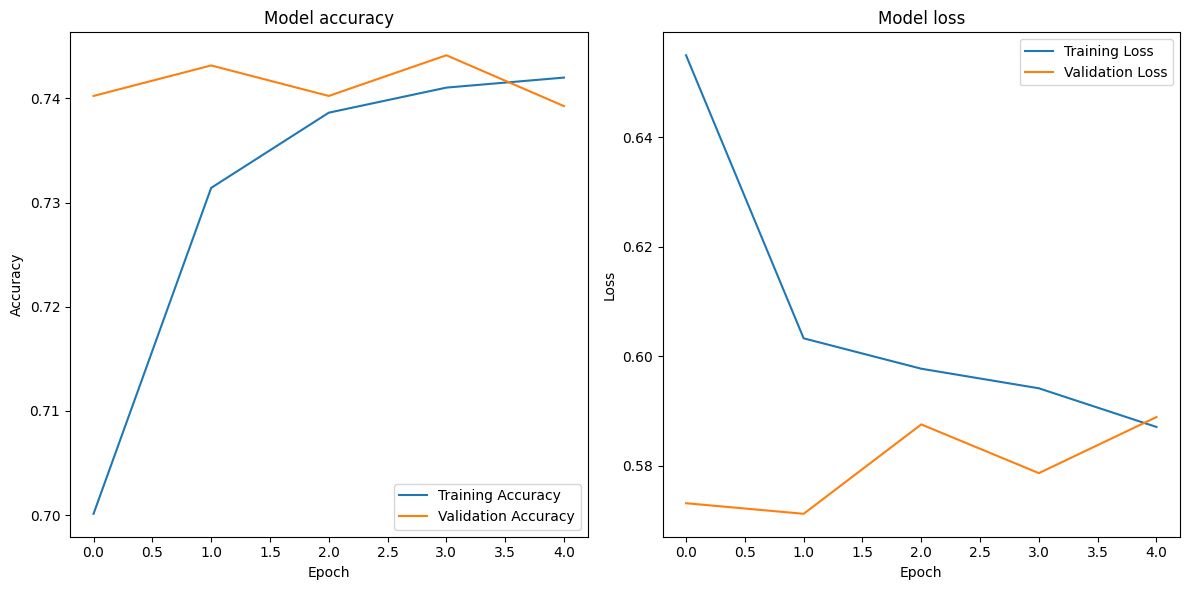

1/1 [==============================] - 2s 2s/step


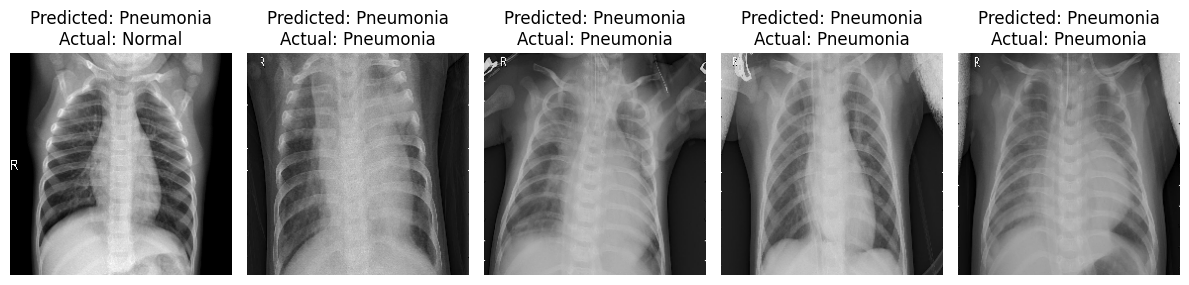

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Visualize training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Visualize predictions on a few test images
def visualize_predictions(model, test_generator, num_images=5):
    class_names = ['MSInstability', 'MSStability']  # Assuming binary classification

    # Get predictions and true labels from the generator
    test_images, true_labels = next(test_generator)
    true_labels = true_labels.astype(int)

    # Make predictions
    predictions = model.predict(test_images)
    predicted_labels = np.round(predictions).astype(int).reshape(-1)

    plt.figure(figsize=(15, 8))  # Increase figure size to accommodate more images
    for i in range(num_images):
        if i >= len(test_images):
            break  # Avoid index error if num_images > available images in the batch
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[i])
        plt.title(f'Predicted: {class_names[predicted_labels[i]]}\nActual: {class_names[true_labels[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with the desired number of images
visualize_predictions(model, test_generator, num_images=10)

**Save The Model**
****

In [ ]:
# Assuming 'model' is your trained Keras model
model.save('/content/drive/MyDrive/Colab Notebooks/EfficientNetB0 Model.h5')


## Evaluation
**Lets see combined result**
****

Found 624 images belonging to 2 classes.
Test Accuracy: 0.7853 - Test Loss: 0.7


20/20 [==============================] - 7s 309ms/step
Found 624 images belonging to 2 classes.
Test Accuracy: 0.7724 - Test Loss: 0.8
20/20 [==============================] - 6s 250ms/step
Found 624 images belonging to 2 classes.
Test Accuracy: 0.7564 - Test Loss: 1.1
20/20 [==============================] - 6s 271ms/step
Found 624 images belonging to 2 classes.
Test Accuracy: 0.7388 - Test Loss: 0.7
20/20 [==============================] - 6s 259ms/step
Found 624 images belonging to 2 classes.
Test Accuracy: 0.6250 - Test Loss: 0.7
20/20 [==============================] - 7s 235ms/step
AlexNet - Confusion Matrix:
[[105 129]
 [  5 385]]
AlexNet - F1 Score: 0.8518
AlexNet - Accuracy: 0.7853
AlexNet - Loss: 0.7
VGG16 - Confusion Matrix:
[[ 94 140]
 [  2 388]]
VGG16 - F1 Score: 0.8453
VGG16 - Accuracy: 0.7724
VGG16 - Loss: 0.8
VGG19 - Confusion Matrix:
[[ 82 152]
 [  0 390]]
VGG19 - F1 Score: 0.8369
VGG19 - Accuracy: 0.7564
VGG19 - Loss: 1.1
ResNet50 - Confusion Matrix:
[[ 74 160]
 [  3 

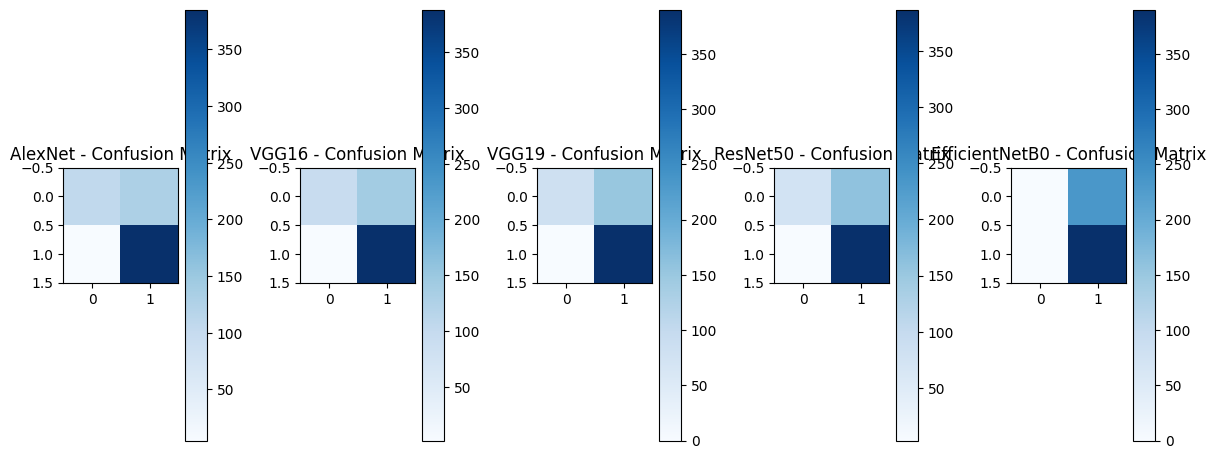

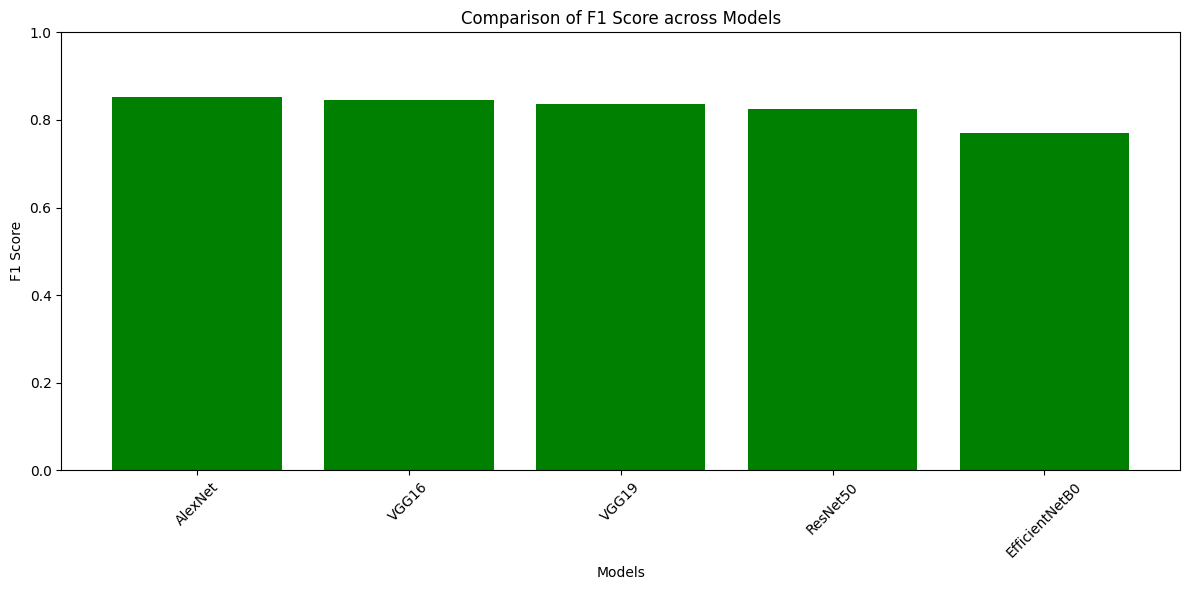

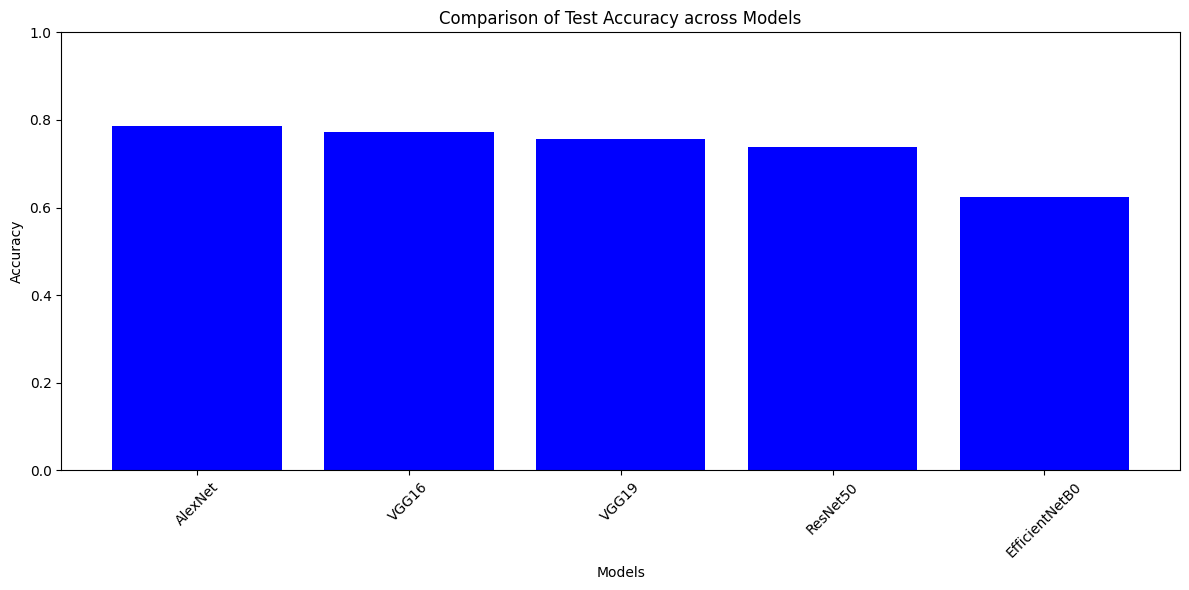

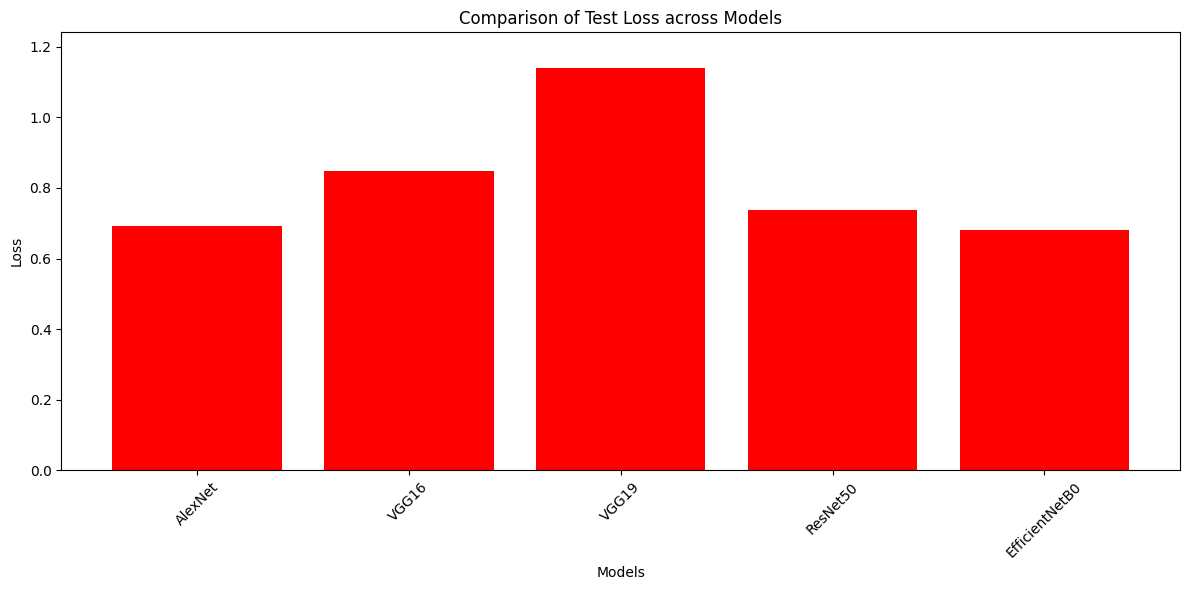

1/1 [==============================] - 0s 64ms/step


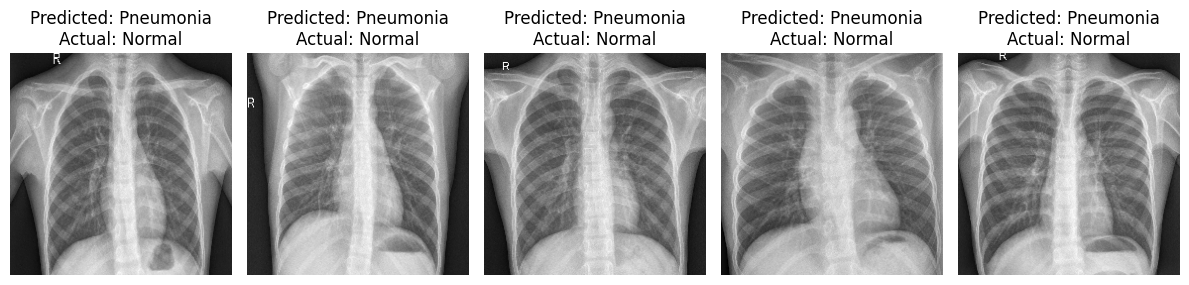

In [ ]:
# Define paths to your saved model weights
model_paths = {
    'AlexNet': '/content/drive/MyDrive/Colab Notebooks/AlexNet Model.h5',
    'VGG16': '/content/drive/MyDrive/Colab Notebooks/VGG16 Model.h5',
    'VGG19': '/content/drive/MyDrive/Colab Notebooks/VGG19 Model.h5',
    'ResNet50': '/content/drive/MyDrive/Colab Notebooks/ResNet50 Model.h5',
    'EfficientNetB0': '/content/drive/MyDrive/Colab Notebooks/EfficientNetB0 Model.h5'
}

# Define function to create test generator based on model path
def create_test_generator(test_data_dir, target_size, batch_size):
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',  # Assuming binary classification
        shuffle=False  # Do not shuffle for confusion matrix and metrics calculation
    )

    return test_generator

# Define function to evaluate model and get metrics
def evaluate_model(model_path, test_generator):
    # Load model
    model = load_model(model_path)

    # Evaluate model on test data
    loss, accuracy = model.evaluate(test_generator, verbose=0)
    print(f'Test Accuracy: {accuracy:.4f} - Test Loss: {loss:.1f}')  # Adjusted to one decimal place

    # Predict classes
    predictions = model.predict(test_generator)
    y_pred = np.round(predictions).flatten().astype(int)  # Convert probabilities to binary predictions

    # True labels
    y_true = test_generator.classes

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)

    return cm, f1, accuracy, loss

# Evaluate each model and collect metrics
metrics = {}
for model_name, model_path in model_paths.items():
    # Define or obtain test generator externally
    test_data_dir = '/content/Pediatric Chest X-ray Pneumonia/test'  # Update with your test data directory
    target_size = (227, 227) if 'AlexNet' in model_path else (224, 224)
    test_generator = create_test_generator(test_data_dir, target_size, batch_size=32)

    # Evaluate model
    cm, f1, accuracy, loss = evaluate_model(model_path, test_generator)
    metrics[model_name] = {'confusion_matrix': cm, 'f1_score': f1, 'accuracy': accuracy, 'loss': loss}

    # Optionally print or process metrics here if needed

# Print confusion matrix, F1 score, accuracy, and loss for each model
for model_name, metric_data in metrics.items():
    formatted_loss = f"{metric_data['loss']:.1f}"  # Format loss to one decimal place
    print(f'{model_name} - Confusion Matrix:')
    print(metric_data['confusion_matrix'])
    print(f'{model_name} - F1 Score: {metric_data["f1_score"]:.4f}')
    print(f'{model_name} - Accuracy: {metric_data["accuracy"]:.4f}')
    print(f'{model_name} - Loss: {formatted_loss}')

# Combine metrics for visualization
models = list(metrics.keys())
accuracies = [metrics[model]['accuracy'] for model in models]
losses = [metrics[model]['loss'] for model in models]

# Plot cumulative confusion matrix
plt.figure(figsize=(12, 6))
for model_name, metric_data in metrics.items():
    plt.subplot(1, len(models), models.index(model_name) + 1)
    plt.imshow(metric_data['confusion_matrix'], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()

plt.tight_layout()
plt.show()

# Plot F1 score comparison chart
plt.figure(figsize=(12, 6))
plt.bar(models, [metrics[model]['f1_score'] for model in models], color='green')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Score across Models')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot accuracy comparison chart
plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color='blue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Test Accuracy across Models')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot loss comparison chart
plt.figure(figsize=(12, 6))
plt.bar(models, losses, color='red')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Comparison of Test Loss across Models')
plt.ylim([0, max(losses) + 0.1])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize predictions on a few test images
def visualize_predictions(model, test_generator, num_images=5):
    class_names = ['Normal', 'Pneumonia']  # Assuming binary classification

    # Get predictions and true labels from the generator
    test_images, true_labels = next(test_generator)
    true_labels = true_labels.astype(int)

    # Make predictions
    predictions = model.predict(test_images)
    predicted_labels = np.round(predictions).astype(int).reshape(-1)

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[i])
        plt.title(f'Predicted: {class_names[predicted_labels[i]]}\nActual: {class_names[true_labels[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_generator)

# CBAM   
****

## Introducing Novel attention module based VGG-16 for optimised performance in Pneumonia detection from chest X-Ray
****
The **Convolutional Block Attention Module (CBAM)** is an attention module designed for *convolutional neural networks (CNNs)*.

**Purpose:**

CBAM enhances feature maps by selectively focusing on important information while suppressing irrelevant details.

**Operation:**
1. Given an intermediate feature map, CBAM sequentially infers attention maps along two dimensions: channel and spatial.

2. These attention maps are then multiplied with the input feature map to refine features adaptively.

**Benefits:**

1. Lightweight and general, CBAM can be integrated into any CNN architecture with minimal overhead.

2. It’s end-to-end trainable alongside base CNNs.

**Applications:**

CBAM has consistently improved *classification and detection tasks* across various models, making it widely applicable.

### Model Implementation

**Install Required Libraries**
****

In [ ]:
#!pip install tensorflow

**Import Required Libraries**
****

In [ ]:
#try:
#  import numpy as np
#  import matplotlib.pyplot as plt
# import tensorflow as tf
#  from tensorflow.keras.models import Sequential
#  from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
#  from tensorflow.keras.optimizers import Adam
#  from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#  from tensorflow.keras.preprocessing.image import ImageDataGenerator
#  print("All libraries imported successfully.")
#except ImportError as e:
#  print(f"Error importing libraries: {e}")

All libraries imported successfully.


**Load & Preprocess the dataset**
****

In [ ]:
# Paths to the dataset
train_dir = '/content/tcga_coad_msi_mss/train'
test_dir = '/content/tcga_coad_msi_mss/test'
val_dir = '/content/tcga_coad_msi_mss/val'

# ImageDataGenerator for training and testing
train_datagen = ImageDataGenerator(rescale=1./255.0)
test_datagen = ImageDataGenerator(rescale=1./255.0)
val_datagen = ImageDataGenerator(rescale=1./255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='binary'
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Define CBAM Modules**
****

In [ ]:
def channel_attention(input_tensor, reduction_ratio=16):
    channel_avg = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
    channel_max = tf.reduce_max(input_tensor, axis=[1, 2], keepdims=True)

    channel_shared = Dense(units=input_tensor.shape[-1] // reduction_ratio, activation='relu', use_bias=True,
                           kernel_initializer='he_normal', bias_initializer='zeros')
    channel_shared_out = Dense(units=input_tensor.shape[-1], activation='sigmoid', use_bias=True,
                              kernel_initializer='he_normal', bias_initializer='zeros')

    avg_out = channel_shared_out(channel_shared(channel_avg))
    max_out = channel_shared_out(channel_shared(channel_max))

    channel_att = tf.multiply(avg_out + max_out, input_tensor)
    return channel_att

def spatial_attention(input_tensor):
    kernel_size = 7
    avg_out = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
    max_out = tf.reduce_max(input_tensor, axis=-1, keepdims=True)

    concat_out = tf.concat([avg_out, max_out], axis=-1)
    concat_out = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid',
                        kernel_initializer='he_normal', bias_initializer='zeros')(concat_out)

    spatial_att = tf.multiply(concat_out, input_tensor)
    return spatial_att

def cbam_block(input_tensor):
    channel_att = channel_attention(input_tensor)
    spatial_att = spatial_attention(channel_att)
    return spatial_att


**Define VGG 16 Model with CBAM Integration**
****

In [ ]:
def vgg16_cbam(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze VGG16 layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add CBAM blocks after some convolutional layers
    x = base_model.layers[-5].output  # Choose a layer before the last pooling layer

    # Apply CBAM block
    x = cbam_block(x)

    # Flatten the output and add dense layers for classification
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='sigmoid')(x)  # For binary classification

    model = Model(inputs=base_model.input, outputs=x)
    return model

# Create the VGG-16 model with CBAM
input_shape = (224, 224, 3)  # Example input shape for VGG-16
num_classes = 1  # Binary classification, change accordingly if multiclass

model = vgg16_cbam(input_shape, num_classes)


**Define model Callbacks**
****

In [ ]:
# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='VGG19.keras',  # Path where the model weights will be saved
    monitor='val_accuracy',    # Quantity to monitor
    mode='max',                # Mode: maximize the quantity
    save_best_only=True,       # Save only the best model (best value of the monitored quantity)
    verbose=1                  # Verbosity level, 1 for updates on save
)

# Define the reduce learning rate on plateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',        # Quantity to monitor
    factor=0.1,                # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,                # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,               # Lower bound on the learning rate
    verbose=1                  # Verbosity level, 1 for updates
)

# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',        # Quantity to monitor
    patience=5,                # Number of epochs with no improvement after which training will be stopped
    verbose=1,                 # Verbosity level, 1 for updates
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Compile the list of callbacks
callbacks_list = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

**Compile the Model**
****

In [ ]:
# Compile the model using the updated parameter name
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])


**Train the Model**
****

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks_list,
    epochs=30
)

Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8629
Epoch 1: val_accuracy improved from -inf to 0.88612, saving model to vgg16_cbam_model.keras
131/131 [==============================] - 56s 407ms/step - loss: 0.3796 - accuracy: 0.8629 - val_loss: 0.3612 - val_accuracy: 0.8861
Epoch 2/20
131/131 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.9135
Epoch 2: val_accuracy improved from 0.88612 to 0.89952, saving model to vgg16_cbam_model.keras
131/131 [==============================] - 54s 412ms/step - loss: 0.2673 - accuracy: 0.9135 - val_loss: 0.2925 - val_accuracy: 0.8995
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9381
Epoch 3: val_accuracy improved from 0.89952 to 0.91388, saving model to vgg16_cbam_model.keras
131/131 [==============================] - 54s 415ms/step - loss: 0.1853 - accuracy: 0.9381 - val_loss: 0.2577 - val_accuracy: 0.9139
Epoch 4/20
131/131 [========

**Evaluate the Model & Visualize the Results**
****

20/20 [==============================] - 5s 239ms/step - loss: 0.7412 - accuracy: 0.7708
Test accuracy: 0.7708333134651184


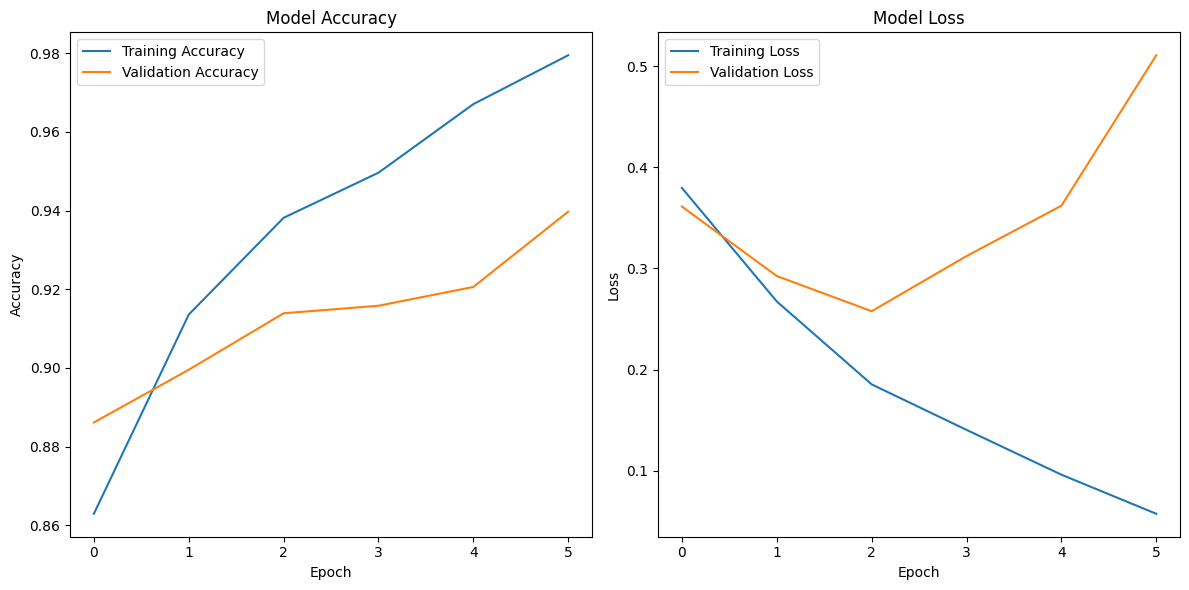

1/1 [==============================] - 0s 204ms/step


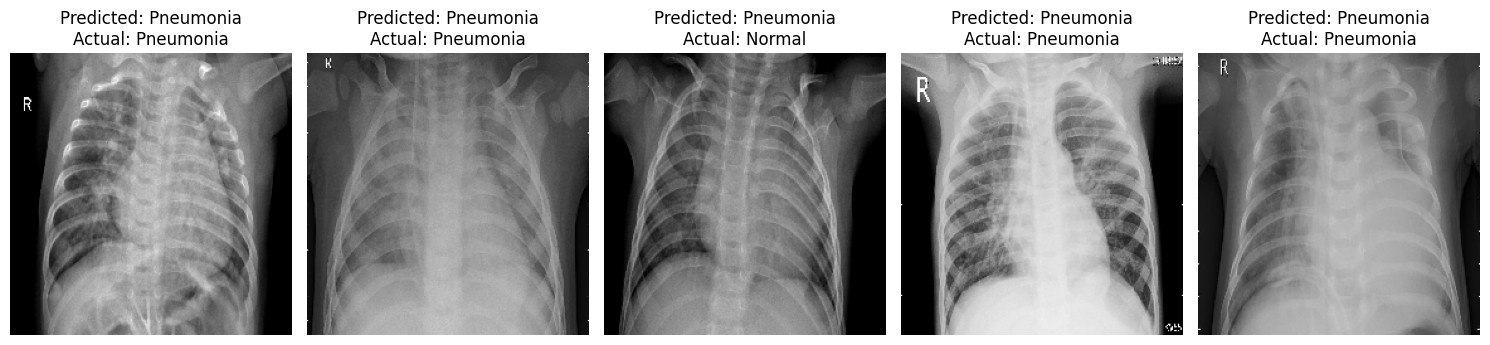

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

# Visualize training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Visualize predictions on a few test images
def visualize_predictions(model, test_generator, num_images=5):
    class_names = ['MSInstability', 'MSStability']  # Assuming binary classification

    # Get predictions and true labels from the generator
    test_images, true_labels = next(test_generator)
    true_labels = true_labels.astype(int)

    # Make predictions
    predictions = model.predict(test_images)
    predicted_labels = np.round(predictions).astype(int).reshape(-1)

    plt.figure(figsize=(15, 8))  # Increase figure size to accommodate more images
    for i in range(num_images):
        if i >= len(test_images):
            break  # Avoid index error if num_images > available images in the batch
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[i])
        plt.title(f'Predicted: {class_names[predicted_labels[i]]}\nActual: {class_names[true_labels[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with the desired number of images
visualize_predictions(model, test_generator, num_images=10)

**Save the Model**
****

In [ ]:
# Assuming 'model' is your trained Keras model
model.save('/content/drive/MyDrive/Colab Notebooks/CBAM-VGG16 model.h5')

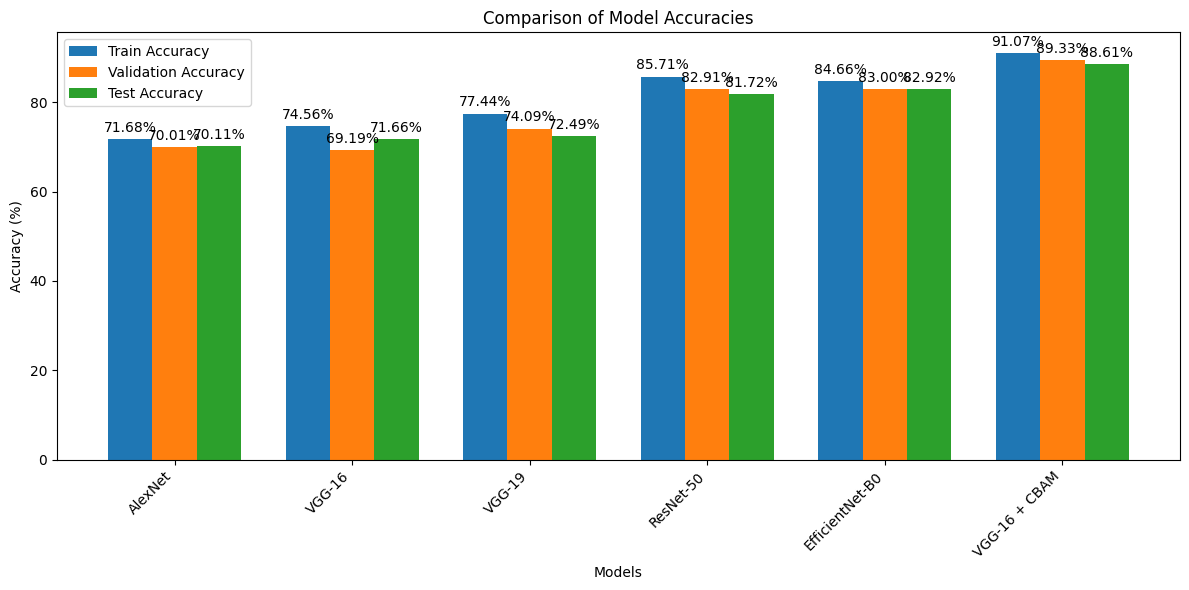

In [ ]:
# Model names
models = ['AlexNet', 'VGG-16', 'VGG-19', 'ResNet-50', 'EfficientNet-B0', 'VGG-16 + CBAM']

# Accuracy values
train_accuracies = [71.68, 74.56, 77.44, 85.71, 84.66, 91.07]
val_accuracies = [70.01, 69.19, 74.09, 82.91, 83.00, 89.33]
test_accuracies = [70.11, 71.66, 72.49, 81.72, 82.92, 88.61]

# Position of the bars on x-axis
x = np.arange(len(models))

# Width of bars
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting bars for each accuracy type
bars1 = ax.bar(x - width, train_accuracies, width, label='Train Accuracy')
bars2 = ax.bar(x, val_accuracies, width, label='Validation Accuracy')
bars3 = ax.bar(x + width, test_accuracies, width, label='Test Accuracy')

# Adding labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of Model Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Adding value labels on the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

fig.tight_layout()
plt.show()


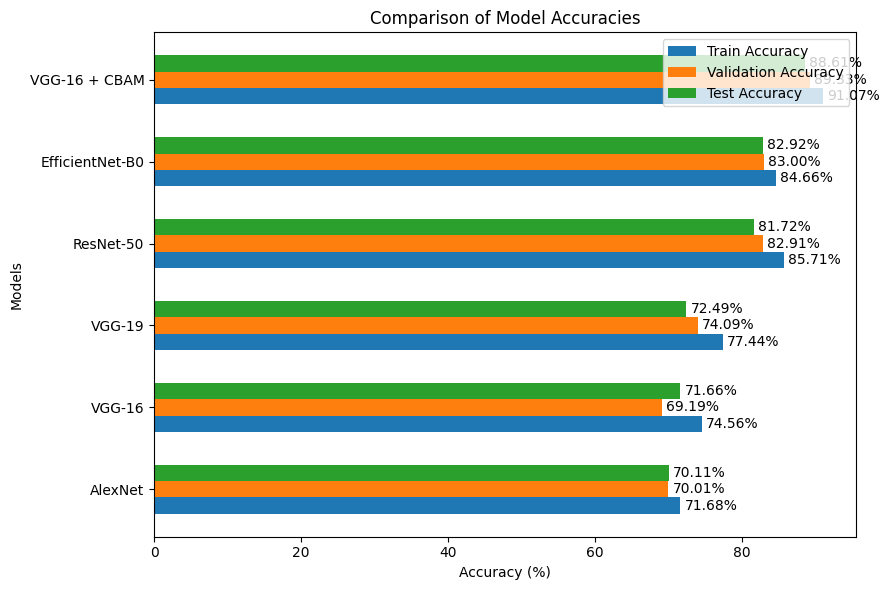

In [ ]:
# Model names
models = ['AlexNet', 'VGG-16', 'VGG-19', 'ResNet-50', 'EfficientNet-B0', 'VGG-16 + CBAM']

# Accuracy values
train_accuracies = [71.68, 74.56, 77.44, 85.71, 84.66, 91.07]
val_accuracies = [70.01, 69.19, 74.09, 82.91, 83.00, 89.33]
test_accuracies = [70.11, 71.66, 72.49, 81.72, 82.92, 88.61]

# Position of the bars on y-axis
y = np.arange(len(models))

# Width of bars
height = 0.2

# Set figure size to be narrower (reduce width)
fig, ax = plt.subplots(figsize=(9, 6))  # Adjust the width here

# Plotting bars for each accuracy type
bars1 = ax.barh(y - height, train_accuracies, height, label='Train Accuracy')
bars2 = ax.barh(y, val_accuracies, height, label='Validation Accuracy')
bars3 = ax.barh(y + height, test_accuracies, height, label='Test Accuracy')

# Adding labels, title, and legend
ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('Models')
ax.set_title('Comparison of Model Accuracies')
ax.set_yticks(y)
ax.set_yticklabels(models)
ax.legend()

# Adding value labels on the bars
def add_value_labels(bars):
    for bar in bars:
        width = bar.get_width()
        ax.annotate(f'{width:.2f}%',
                    xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

fig.tight_layout()
plt.show()
